In [1]:
import pandas as pd
from hurst import compute_Hc
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
import numpy as np
import seaborn as sns
import plotly.express as px
import warnings 
warnings.filterwarnings('ignore')

In [2]:
DATA_DIR = 'data/'

In [3]:
fx_list = ['EURCZK', 'AUDUSD', 'EURHUF', 'EURNOK', 'EURPLN',
           'EURSEK', 'EURUSD', 'GBPUSD', 'NZDUSD', 'USDCAD',
           'USDCHF', 'USDCNH', 'USDILS', 'USDJPY', 'USDMXN', 
           'USDSGD', 'USDZAR']

In [4]:
future_df = pd.read_parquet(DATA_DIR+f'futures_1min_bar.parquet')

future_df = future_df.sort_values(by='timestamp')
future_df = future_df[~future_df.bid.isna()]
future_df['Roll Adjusted Bid'] = future_df['bid'] + future_df['adjustment']
future_df['Roll Adjusted Offer'] = future_df['offer'] + future_df['adjustment']
future_df['mid_price'] = (future_df['Roll Adjusted Bid'] + future_df['Roll Adjusted Offer']) / 2
print(future_df.shape)
future_df.head(2)

(312822, 11)


,contract,instrument,bid,offer,bid_size,offer_size,timestamp,adjustment,Roll Adjusted Bid,Roll Adjusted Offer,mid_price
0,ES,ESZ3,4572.75,4573.00,21,31,2023-12-01 00:01:00,316.375,4889.125,4889.375,4889.25
1,ES,ESZ3,4572.50,4572.75,31,23,2023-12-01 00:02:00,316.375,4888.875,4889.125,4889.00


In [53]:
future_df.isna().mean()

contract               0.0
instrument             0.0
bid                    0.0
offer                  0.0
bid_size               0.0
offer_size             0.0
timestamp              0.0
adjustment             0.0
Roll Adjusted Bid      0.0
Roll Adjusted Offer    0.0
mid_price              0.0
dtype: float64

In [48]:
for fx in fx_list:
    try:
        cur_data = pd.read_parquet(DATA_DIR+f'{fx}_data.parquet')
        print(fx, cur_data.shape)
    except Exception as e:
        print(e)
        continue 

EURCZK (1151405, 4)
AUDUSD (1176103, 4)
EURHUF (1152347, 4)
EURNOK (1173941, 4)
EURPLN (1153173, 4)
EURSEK (1154995, 4)
EURUSD (1179255, 4)
GBPUSD (1176068, 4)
NZDUSD (1176046, 4)
USDCAD (1175941, 4)
USDCHF (1176588, 4)
USDCNH (1176026, 4)
USDILS (1139866, 4)
USDJPY (1175716, 4)
USDMXN (1174505, 4)
USDSGD (1177216, 4)
USDZAR (1173943, 4)


# Hurst Exponent

In [51]:
cur_data.sample(100)

,instrument,bid,offer,timestamp
378414,"""USDZAR""",NaN,NaN,2023-01-06 00:49:00
1144114,"""USDZAR""",18.68812,18.70070,2025-01-29 02:46:00
605010,"""USDZAR""",19.05800,19.06962,2023-08-18 06:11:00
339052,"""USDZAR""",16.99572,17.00077,2022-11-29 16:08:00
1133245,"""USDZAR""",18.73142,18.73993,2025-01-17 12:25:00
...,...,...,...,...
464211,"""USDZAR""",17.89259,17.90087,2023-04-04 13:19:00
955565,"""USDZAR""",18.24494,18.25159,2024-07-26 10:35:00
774991,"""USDZAR""",18.64894,18.66060,2024-02-01 03:51:00
922958,"""USDZAR""",18.22140,18.23082,2024-06-25 19:22:00


In [5]:
hurst_df = [['feature', compute_Hc(future_df['mid_price'], kind='price', simplified=False)[0]]]

for fx in tqdm(fx_list):
    cur_data = pd.read_parquet(DATA_DIR+f'{fx}_data.parquet')
    cur_data['mid_price'] = (cur_data['bid'] + cur_data['offer'])/2
    cur_data = cur_data[~cur_data.mid_price.isna()].sort_values(by='timestamp')
    hurst_value, _, _ = compute_Hc(cur_data['mid_price'], kind='price', simplified=True)

    hurst_df.append([fx, hurst_value])

hurst_df = pd.DataFrame(hurst_df, columns = ['data', 'hurst_value'])

px.bar(
    hurst_df.sort_values(by='hurst_value'),
    x='hurst_value',
    y='data'
)

100%|██████████| 17/17 [01:15<00:00,  4.47s/it]


In [ ]:
# from joblib import Parallel, delayed

# def block_bootstrap_hurst(series, n_iter=50, n_jobs=-1):
#     """
#     Блочный бутстрап для временных рядов: сохраняет временную структуру внутри блоков.

#     :param series: 1D массив (временной ряд)
#     :param block_size: размер блока (например, 50)
#     :param n_iter: количество бутстрап-итераций
#     :param n_jobs: число потоков для параллелизации
#     :param show_progress: показывать ли прогресс-бар
#     :return: (95% доверительный интервал, среднее значение Hurst)
#     """
#     series = np.asarray(series)
#     n = len(series)

#     def one_iter(_):
#         block_finish = np.random.randint(100_000, n + 1)
#         blocks = series[:block_finish]
#         H, _, _ = compute_Hc(blocks, kind='price', simplified=False)
#         return H

#     results = Parallel(n_jobs=n_jobs)(
#         delayed(one_iter)(i) for i in tqdm(range(n_iter))
#     )
    

#     return np.percentile(results, [2.5, 97.5]), np.mean(results)


# hurst_df_ci = []

# ci, mean_hurst = block_bootstrap_hurst(future_df['mid_price'].dropna().values)
# hurst_df_ci.append(['feature', mean_hurst, ci[0], ci[1]])

# for fx in tqdm(fx_list):
#     cur_data = pd.read_parquet(DATA_DIR+f'{fx}_data.parquet')
#     cur_data['mid_price'] = (cur_data['bid'] + cur_data['offer'])/2
#     cur_data = cur_data[~cur_data.mid_price.isna()].sort_values(by='timestamp')
#     ci, mean_hurst = block_bootstrap_hurst(cur_data['mid_price'].dropna().values)

#     hurst_df_ci.append([fx, mean_hurst, ci[0], ci[1]])

100%|██████████| 50/50 [00:06<00:00,  8.11it/s]


In [6]:
def bootstrap_hurst(series, n_iter=100, sample_frac=0.8, n_jobs=-1):
    series = np.asarray(series)
    n = len(series)
    sample_size = int(n * sample_frac)

    # Внутренняя функция для одной итерации
    def one_bootstrap():
        idx = np.random.choice(n, size=sample_size, replace=False)
        sample = series[np.sort(idx)]
        H, _, _ = compute_Hc(sample, kind='price', simplified=False)
        return H

    # Параллельное выполнение
    hurst_vals = Parallel(n_jobs=n_jobs)(
        delayed(one_bootstrap)() for _ in tqdm(range(n_iter), desc='Bootstaping...')
    )

    return np.percentile(hurst_vals, [2.5, 97.5]), np.mean(hurst_vals)

In [7]:
hurst_df_ci = []

ci, mean_hurst = bootstrap_hurst(future_df['mid_price'].dropna().values)
hurst_df_ci.append(['feature', mean_hurst, ci[0], ci[1]])

Bootstaping...: 100%|██████████| 100/100 [00:16<00:00,  6.06it/s]


In [11]:
for fx in fx_list:
    cur_data = pd.read_parquet(DATA_DIR+f'{fx}_data.parquet')
    cur_data['mid_price'] = (cur_data['bid'] + cur_data['offer'])/2
    cur_data = cur_data[~cur_data.mid_price.isna()].sort_values(by='timestamp')
    ci, mean_hurst = bootstrap_hurst(cur_data['mid_price'].dropna().values)

    hurst_df_ci.append([fx, mean_hurst, ci[0], ci[1]])
    print(fx)


Bootstaping...: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


EURCZK


Bootstaping...: 100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


AUDUSD


Bootstaping...:  40%|████      | 40/100 [00:17<00:28,  2.09it/s]

KeyboardInterrupt: 

In [17]:
hurst_df_ci = pd.DataFrame(hurst_df_ci, columns=['data', 'hurst_value', 'ci_low', 'ci_high'])

In [18]:
px.bar(
    hurst_df_ci.sort_values(by='hurst_value'),
    x='hurst_value',
    y='data',
    error_x=hurst_df_ci['ci_high'] - hurst_df_ci['hurst_value'],
    error_x_minus=hurst_df_ci['hurst_value'] - hurst_df_ci['ci_low'],
    title='Hurst Exponent with 95% Confidence Intervals'
)

Bootstaping...:  47%|████▋     | 47/100 [02:04<02:20,  2.66s/it]


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_variance_ratio(returns, q_max=20):
    """
    Расчет VR(q) для лагов от 2 до q_max.
    :param returns: np.array — лог-доходности
    :param q_max: максимальный лаг q
    :return: DataFrame c колонками q и VR(q)
    """
    vr_values = []
    for q in range(2, q_max + 1):
        weighted_sum = 0
        for k in range(1, q):
            weight = 1 - k / q
            corr = np.corrcoef(returns[:-k], returns[k:])[0, 1]
            weighted_sum += weight * corr
        vr_q = 1 + 2 * weighted_sum
        vr_values.append((q, vr_q))
    return pd.DataFrame(vr_values, columns=["q", "VR"])


In [27]:
def plot_vr_for_assets(asset_dict, q_max=20):
    """
    Построение VR-графиков для нескольких активов.
    :param asset_dict: словарь вида {'ES': prices_ES, 'EURUSD': prices_eur, ...}
    """
    plt.figure(figsize=(12, 6))
    for name, price_series in tqdm(asset_dict.items()):
        returns = np.diff(np.log(price_series))
        vr_df = calculate_variance_ratio(returns, q_max=q_max)
        plt.plot(vr_df['q'], vr_df['VR'], label=name)

    plt.axhline(1.0, color='gray', linestyle='--', label='Random Walk')
    plt.xlabel("Lag q")
    plt.ylabel("Variance Ratio")
    plt.title("Variance Ratio vs Lag q")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [28]:
# Пример: загрузка фьючерса ES и нескольких FX-пар
 # примеры Major + EM

asset_prices = {}
for fx in tqdm(fx_list[:5]):
    df = pd.read_parquet(DATA_DIR + f'{fx}_data.parquet')
    df['mid_price'] = (df['bid'] + df['offer']) / 2
    df = df.sort_values(by='timestamp')
    asset_prices[fx] = df['mid_price'].dropna().values


100%|██████████| 5/5 [00:00<00:00,  8.11it/s]


100%|██████████| 5/5 [02:32<00:00, 30.59s/it]


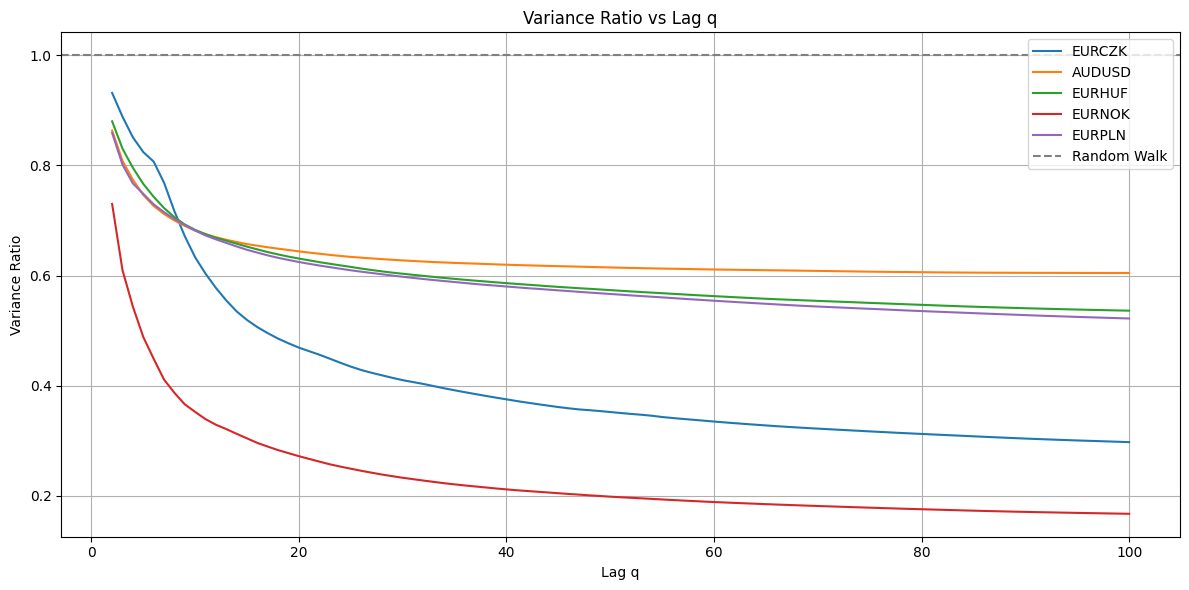

In [29]:
# Построение VR-графика
plot_vr_for_assets(asset_prices, q_max=100)

In [31]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from tqdm import tqdm

def compute_returns(prices, interval):
    return np.log(prices[interval:] / prices[:-interval])

def correlation_table(prices, lookbacks=[5, 10, 15, 30], holds=[1, 5, 10]):
    """
    Построение таблицы корреляций между доходностью Lookback и Hold периодов
    :param prices: массив цен (с равномерным интервалом, например, 1 минута)
    :param lookbacks: список lookback периодов в минутах
    :param holds: список hold периодов в минутах
    :return: DataFrame с колонками: LookBack, Hold, Correlation, P-value, Score
    """
    results = []
    prices = np.array(prices)

    for lb in tqdm(lookbacks):
        for h in holds:
            # Считаем доходность за lookback и hold, без пересечений
            step = lb + h
            n = (len(prices) - step)

            if n <= 0:
                continue

            lookback_returns = np.log(prices[lb:lb + n] / prices[:n])
            hold_returns = np.log(prices[lb + h:lb + h + n] / prices[lb:lb + n])

            # Проверим на NaN и рассчитаем корреляцию
            mask = ~np.isnan(lookback_returns) & ~np.isnan(hold_returns)
            if np.sum(mask) < 10:
                continue

            corr, pval = pearsonr(lookback_returns[mask], hold_returns[mask])
            score = abs(corr) / pval if pval > 0 else np.nan

            results.append([lb, h, corr, pval, score])

    return pd.DataFrame(results, columns=['LookBack', 'Hold', 'Correlation', 'P-value', 'Score'])


In [44]:
df = pd.read_parquet(DATA_DIR + 'AUDUSD_data.parquet')
df['mid_price'] = (df['bid'] + df['offer']) / 2
df = df.sort_values('timestamp')

returns_table = correlation_table(df['mid_price'].dropna().values, lookbacks=range(5,61,1), holds=range(5,61,1))

# Смотрим топ-10 пар по метрике "выгодности"
returns_table.sort_values('Score', ascending=False).head(10)


100%|██████████| 56/56 [01:23<00:00,  1.50s/it]


,LookBack,Hold,Correlation,P-value,Score
46,5,51,-0.035478,7.103676e-319,inf
1629,34,10,-0.035482,5.956357e-319,inf
472,13,29,-0.035712,4.940656e-323,inf
1796,37,9,-0.035512,1.737234e-319,inf
1852,38,9,-0.035104,3.051975e-312,inf
692,17,25,-0.035499,2.921015e-319,inf
418,12,31,-0.035270,3.552369e-315,inf
2019,41,8,-0.035164,2.621299e-313,inf
2130,43,7,-0.035713,4.940656e-323,inf
2186,44,7,-0.035608,3.250952e-321,inf


In [45]:
returns_table['Correlation_abs'] = returns_table['Correlation'].abs()

In [46]:
fig = px.scatter(returns_table, x="LookBack", y="Hold", color="P-value",
                 size='Correlation_abs')
fig.show()

In [ ]:
fig_3d = px.scatter_3d(
    returns_table,
    x="LookBack",
    y="Hold",
    z="Correlation_abs",
    color="P-value",
    size="Correlation_abs",
    title="3D визуализация зависимости корреляции от LookBack и Hold"
)

fig_3d.update_layout(scene=dict(
    xaxis_title='LookBack (мин)',
    yaxis_title='Hold (мин)',
    zaxis_title='Correlation'
))

fig_3d.show()